### DBScan

### Data
In this assignment, three datasets with different shapes and numbers of clusters are provided that the k-means algorithm fails to cluster correctly. Each dataset contains 1500 samples, and each sample has two dimensions (x and y).

### Implementation
• You need to code the algorithm you are implementing from scratch. However, you are allowed to use Python built-in functions, such as min, max, average, map, apply, reduce, etc. You are allowed to use numpy.

• Make sure that the cells of your notebook are ordered correctly so that the “run all” option can run all cells without running to dependency issues.

• You can lose up to 30 points for bad code quality (readability, modularity, comments, efficiency, etc.) and formatting of the output files.

In [2]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings # for hiding warnings
warnings.filterwarnings('ignore')

### Case-Study
- Parameters:
    
    • dataset_name: this is the dataset name (such as moons.csv). Assume the dataset is located in the same folder as your notebook.
    
    • min_points: a list of integers indicating the minimum number of points required in the neighborhood of a core object
    
    • epsilons: a list of floats for neighborhood radius

In [3]:
base_path = r'C:\Users\wayiqin\Downloads\Data_mining\Assignment3' # path to the folder that contains the dataset.csv.
dataset_name = 'circles.csv'
dataset_path = rf'{base_path}/{dataset_name}'
dataset = pd.read_csv(dataset_path, header=None) # extract each trasaction in each line
# One example parameter
epsilons = 0.1
min_points = 12

### 1. Implement the DBScan Algorithm
Implement the DBScan algorithm. You need a function named dbscan that takes three arguments (dataset, epsilon, and min_points) and returns a clustering.

In [4]:
## Euclidean distance formular
def ecli_dis(point_a,point_b):
    return np.linalg.norm(point_a - point_b)

In [5]:
## For the current point p, judge the point is or not its neigbor
def eps_neighbor(p,q,eps):
    return ecli_dis(p,q) < eps

In [6]:
## For the current point, find out all of its neighbor points
def region(m, point_id, eps):
    point_num = m.shape[0]
    seed = []
    for i in range(0, point_num):
        if eps_neighbor(m.loc[point_id],m.loc[i], eps):
            seed.append(i)
    return seed

In [7]:
## Find out all points in this cluster 
def expand_cluster(m, classifications, point_id, cluster_id, eps, min_points):
    seeds = region(m, point_id, eps)
    # if the number of seeds is less than min point, so this point is a noise
    if len(seeds) < min_points:
        classifications[point_id] = NOISE
        return False
    else:
        classifications[point_id] = cluster_id
        for seed_id in seeds:
            classifications[seed_id] = cluster_id
        # else, this point is a core point    
        while len(seeds) > 0:
            # for each neighbor point, find out its neighbors are or not core point
            current_point = seeds[0]
            results = region(m, current_point, eps)
            if len(results) >= min_points:
                for i in range(0, len(results)):
                    result_point = results[i]
                    if classifications[result_point] == UNCLASSIFIED or classifications[result_point] == NOISE:
                        if classifications[result_point] == UNCLASSIFIED:
                            seeds.append(result_point)
                        classifications[result_point] = cluster_id
            seeds = seeds[1:]
        return True

In [8]:
## The dbscan algorithm
def dbscan(m, eps, min_points):
    cluster_id = 1
    point_num = m.shape[0]
    classifications = [UNCLASSIFIED] * point_num # firstly define a unclassified list
    for point_id in range(0, point_num):
        point = m.loc[point_id]
        if classifications[point_id] == UNCLASSIFIED:
            if expand_cluster(m, classifications, point_id, cluster_id, eps, min_points):
                cluster_id = cluster_id + 1
    return classifications

### 2. Clustering Evaluation
Evaluation metric: implement the silhouette measure from scratch to evaluate each clustering.

In [9]:
## find out the index of target in the list 
def find_with_list(myList, target):
    inds = []
    for i in range(len(myList)):
        if myList[i] == target:
            inds.append(i)
    return inds

In [10]:
# calulate the silhouette of the single point
def single_silhouette(m, clusters, current_point, current_cluster):
    
    cluster_label = list(set(clusters))
    
    #Handle condition when |C| is 1
    if clusters.count(current_cluster) == 1:
        return 0
    
    #Calculate ai
    
    distance_ai = 0
    cluster_size_ai = 0
    for i in range(len(clusters)):
        if clusters[i] == current_cluster:
            instance = m.loc[i]
            distance_ai += ecli_dis(instance, current_point)
            cluster_size_ai += 1
    
    cluster_size_ai = cluster_size_ai - 1
    
    ai = distance_ai / cluster_size_ai
    
    #Calculate bi
    all_bi = []
    for c in cluster_label:
        #skip the cluster the current point is in
        if c == current_cluster:
            continue
            
        distance_bi = 0
        indices = find_with_list(clusters, c) 
        cluster_size_bi = len(indices)
        for j in indices:
            neibor = m.loc[j]
            distance_bi += ecli_dis(neibor, current_point)
            
        all_bi.append( distance_bi / cluster_size_bi )
    if len(all_bi) == 0:
        return 0
    else:
        bi = min(all_bi)
    
    #calculate the silhouette score
    if ai > bi:
        return round((( bi - ai ) / ai), 2)
    else:
        return round((( bi - ai ) / bi), 2)

In [11]:
# get the mean silhouette value of all points
def silhouette_scores(m, clusters): 
    scores = []
    cluster_label = list(set(clusters))
    for label in cluster_label:
        if label == None:
            continue
        
        indices = find_with_list(clusters, label)
        for i in indices:
            current_point = m.loc[i]
            current_cluster = clusters[i]        
            scores.append(single_silhouette(m, clusters, current_point, current_cluster))
            
    scores = np.array(scores)
    silhouette = np.mean(scores)
        
    
    return silhouette

### 3. Clustering Visualization and Parameter Tuning
Visualization: Use matplotlib to visualize the clusters. Distinguish each cluster with a different color. Use black to display the outlier points.

Parameters tuning: run your code with the provided parameter sets for each dataset. For each dataset, visualize the resulting clusterings for each parameter set. The title of each chart should follow this format:

In [12]:
## visualize the clusters. Distinguish each cluster with a different color. Use black to display the outlier points. 
def draw(m, clusters, eps, min_point, silhouette, k):
    plt.figure(figsize=(10, 10))
    for label in list(set(clusters)):
        indices = find_with_list(clusters, label)
        if label == None:            
            plt.scatter(m.iloc[indices,0], m.iloc[indices,1], marker='o', c='black')
        else:
            rgb = (random.random(), random.random(), random.random())
            plt.scatter(m.iloc[indices,0], m.iloc[indices,1], marker='o', c= rgb)
    plt.title(f'epsilon:{eps},min_points:{min_point}, cluster:{k}, silhouette:{silhouette}', fontdict={'fontsize': 15})
    plt.xlabel('X', fontsize = 20.0)
    plt.ylabel('Y', fontsize = 20.0)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


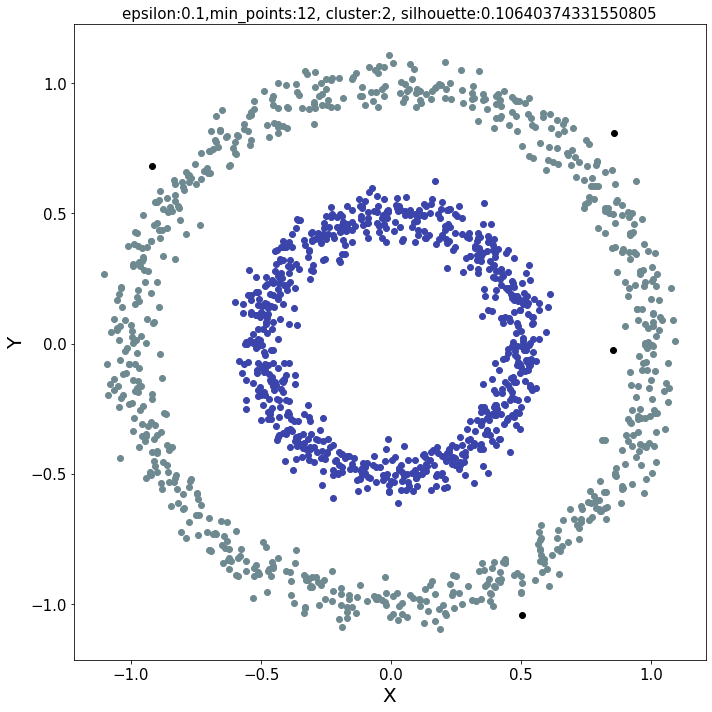

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

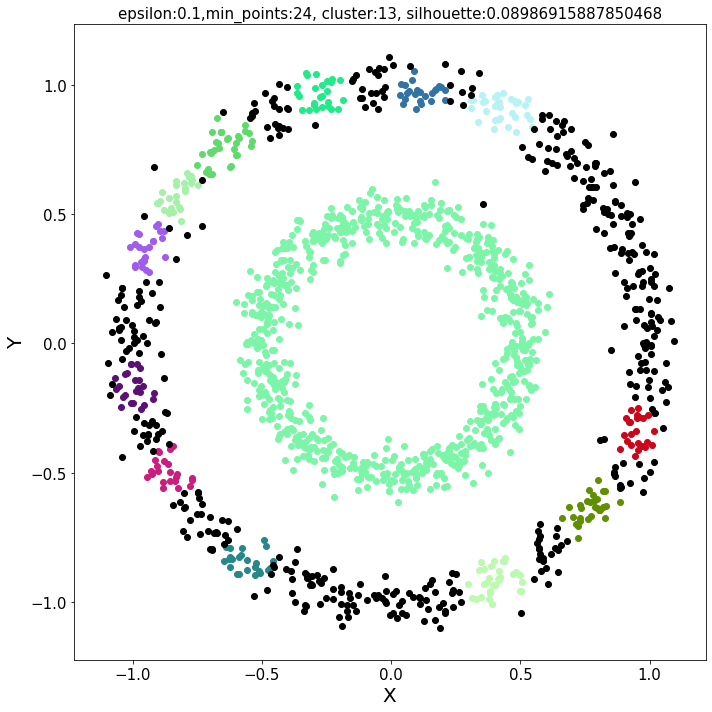

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


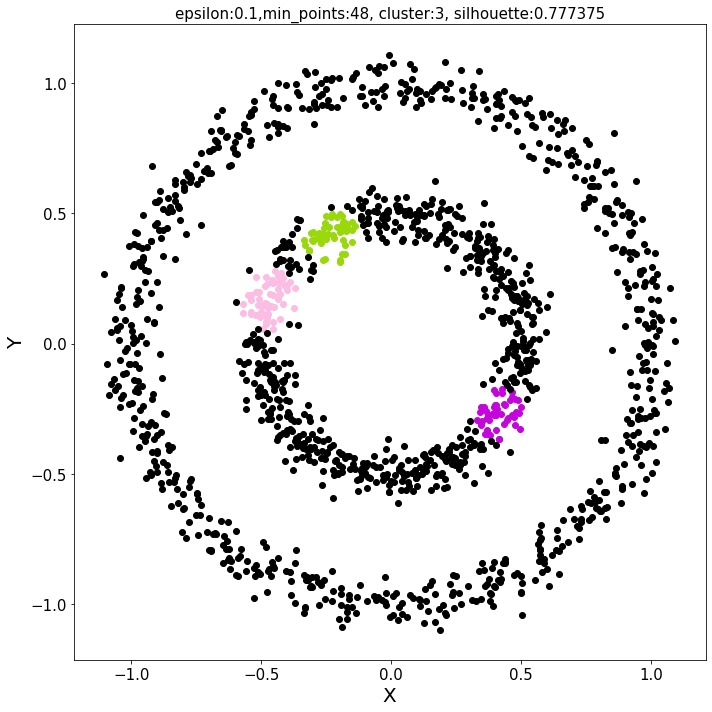

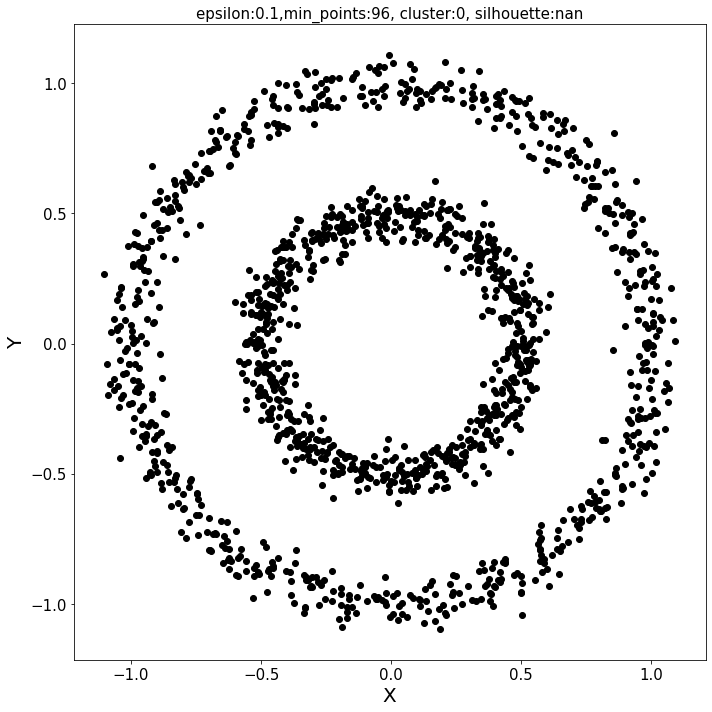

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


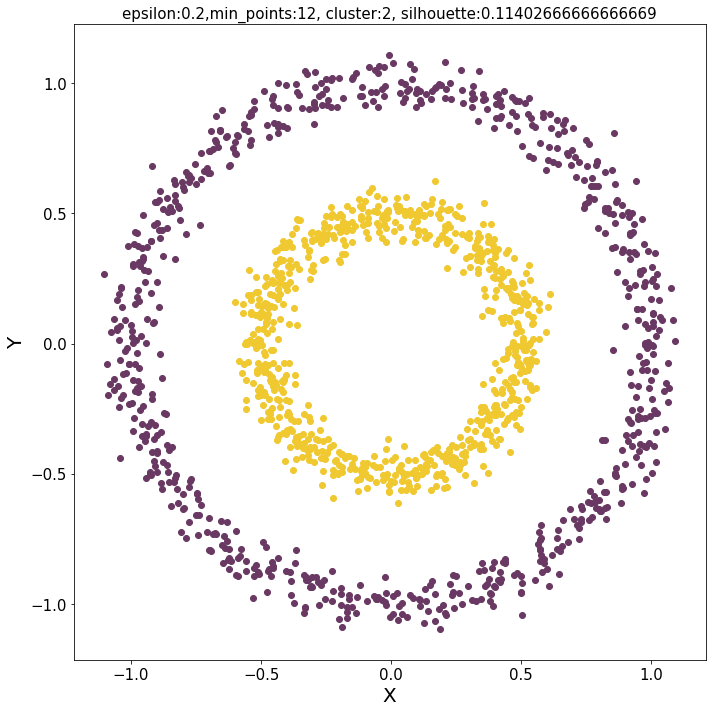

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


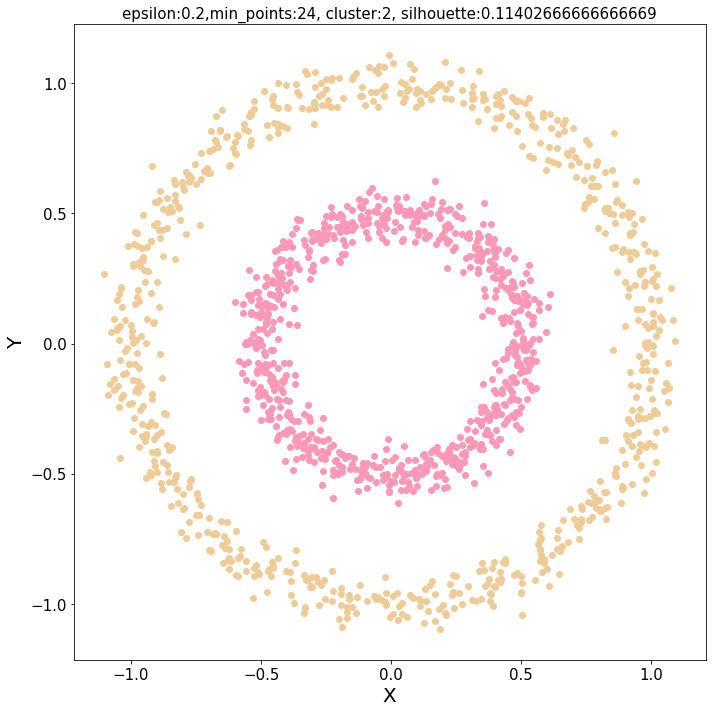

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

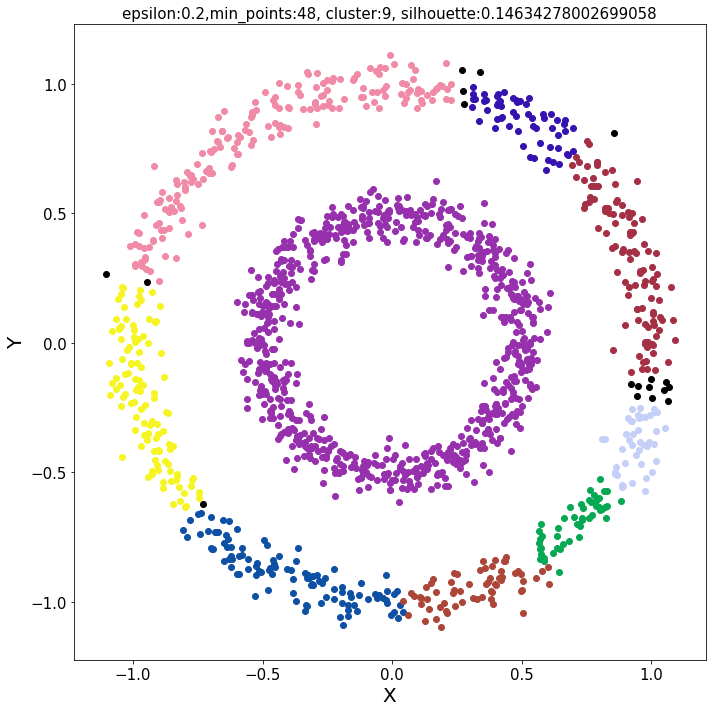

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


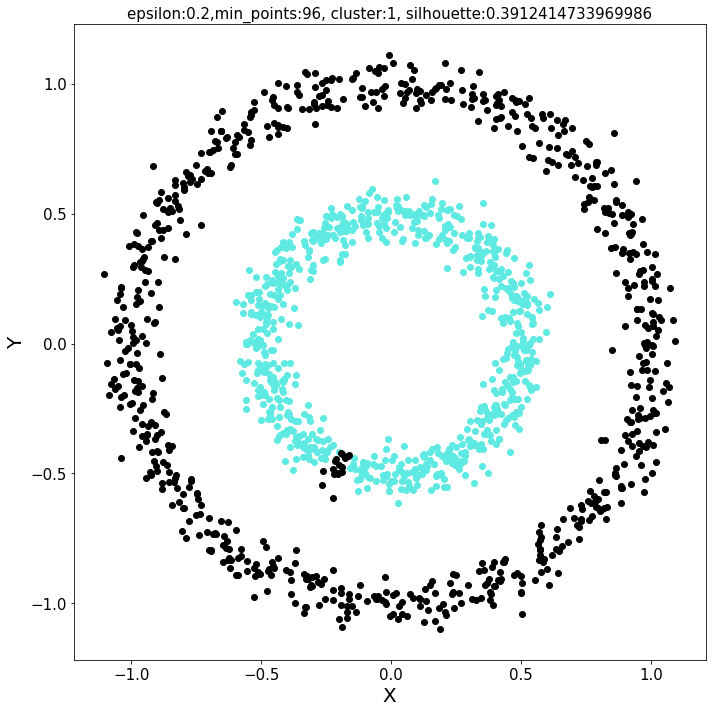

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


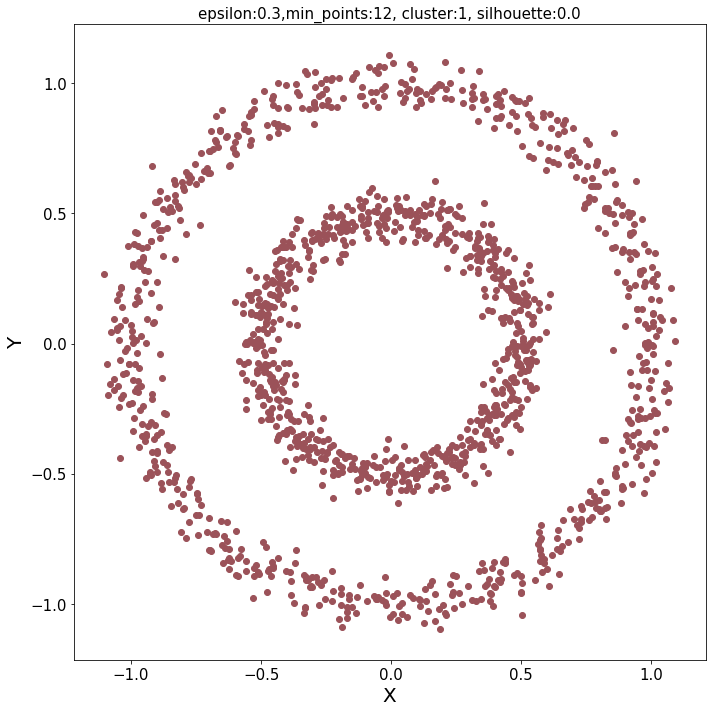

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


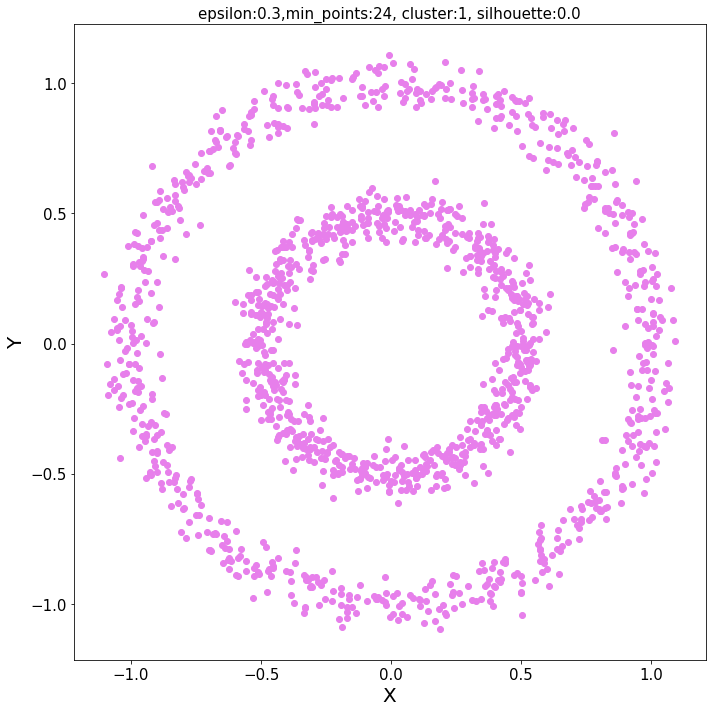

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


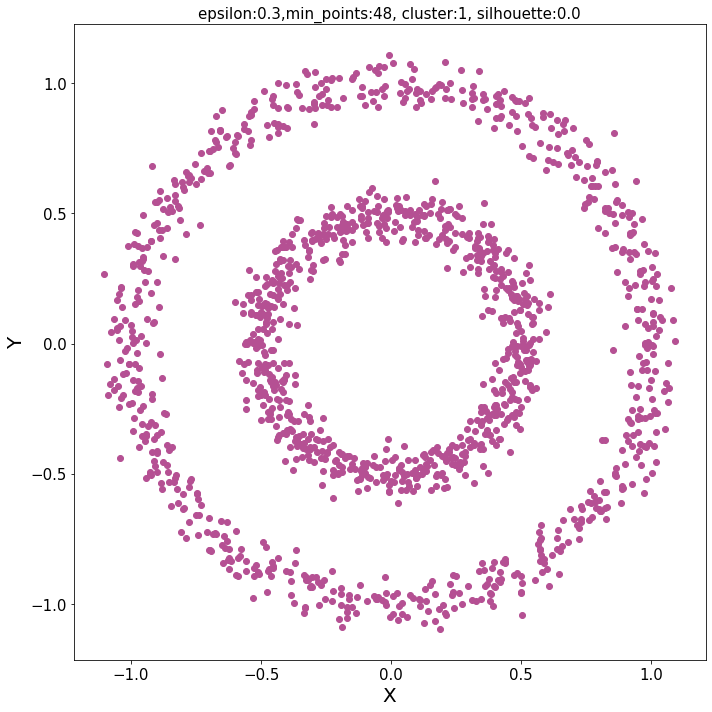

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


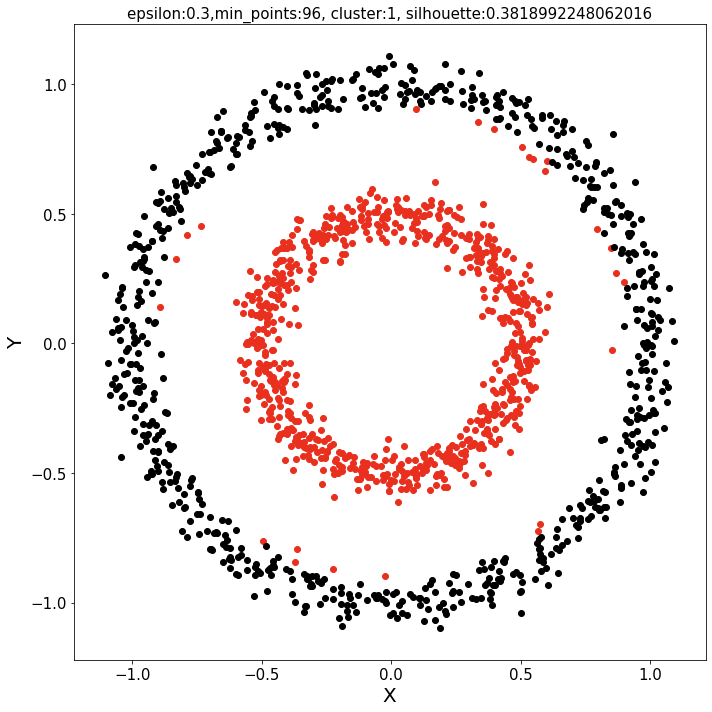

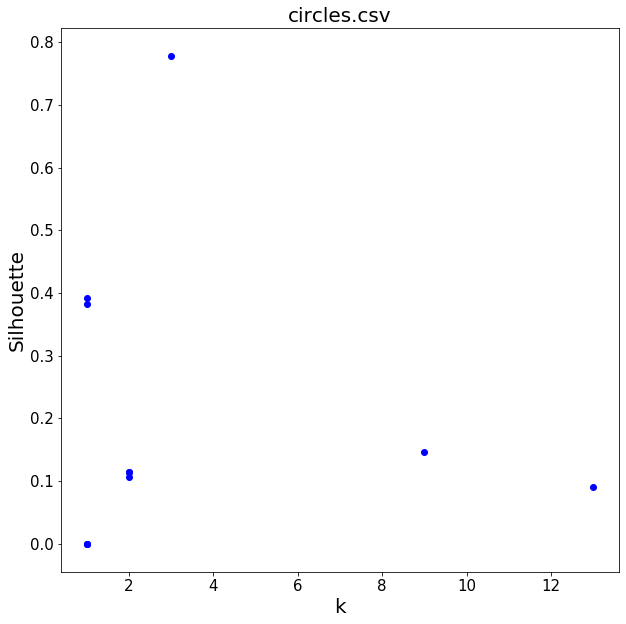

In [65]:
## For the circle dataset, the result is shown
base_path = r'C:\Users\wayiqin\Downloads\Data_mining\Assignment3' # path to the folder that contains the dataset.csv.
dataset_name = 'circles.csv'
dataset_path = rf'{base_path}/{dataset_name}'
dataset = pd.read_csv(dataset_path, header=None) # extract each trasaction in each line
epsilons = [0.1, 0.2, 0.3]
min_points = [12, 24, 48, 96]
m = dataset
cluster_number = []
silhouettes = []
for epsilon in epsilons:
    for min_point in min_points:
        UNCLASSIFIED = False
        NOISE = None        
        clusters = dbscan(m, epsilon, min_point)
        if None in list(set(clusters)):
            k = len(list(set(clusters)))-1
            cluster_number.append(k)
        else:
            k = len(list(set(clusters)))
            cluster_number.append(k)
        silhouette = silhouette_scores(m, clusters)
        silhouettes.append(silhouette)
        draw(m, clusters, epsilon, min_point, silhouette, k)

# draw the silhouettes in a graph
plt.figure(figsize=(10, 10))
plt.title(dataset_name, fontsize = 20.0)
plt.scatter(cluster_number, silhouettes, marker='o', c='blue')
plt.xticks(fontsize = 15.0)
plt.yticks(fontsize = 15.0)
plt.xlabel('k', fontsize = 20.0)
plt.ylabel('Silhouette', fontsize = 20.0)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


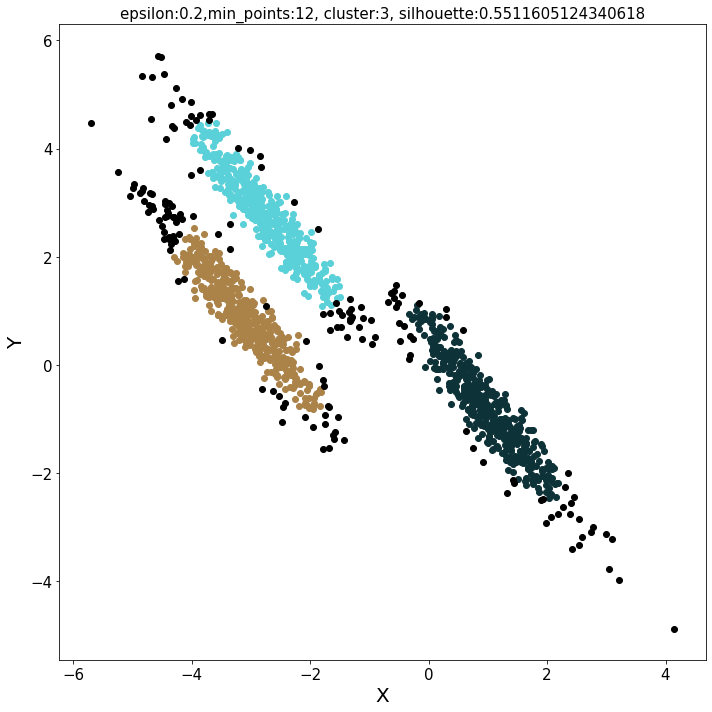

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


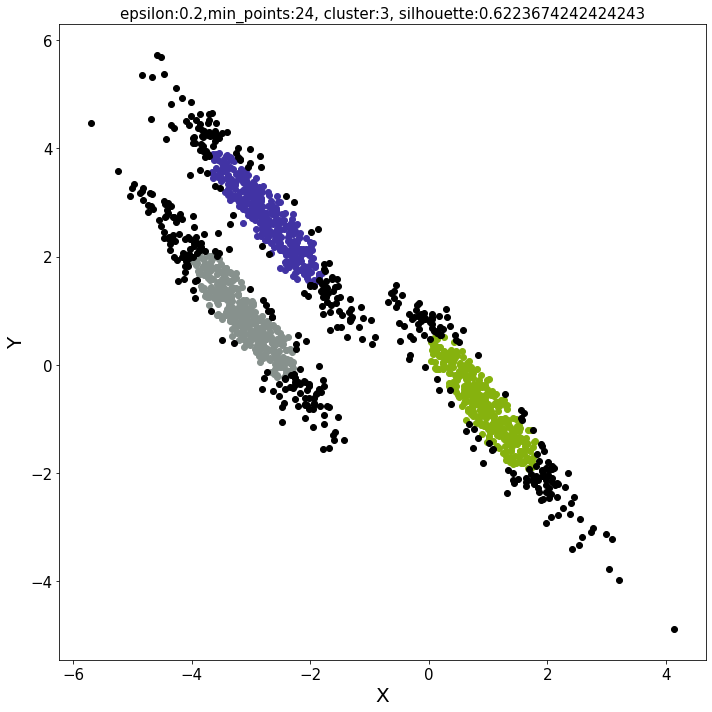

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


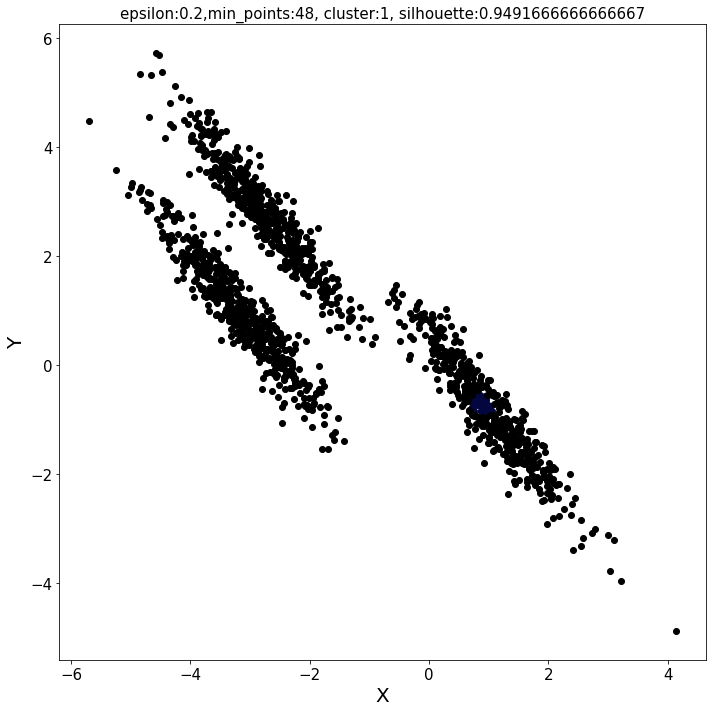

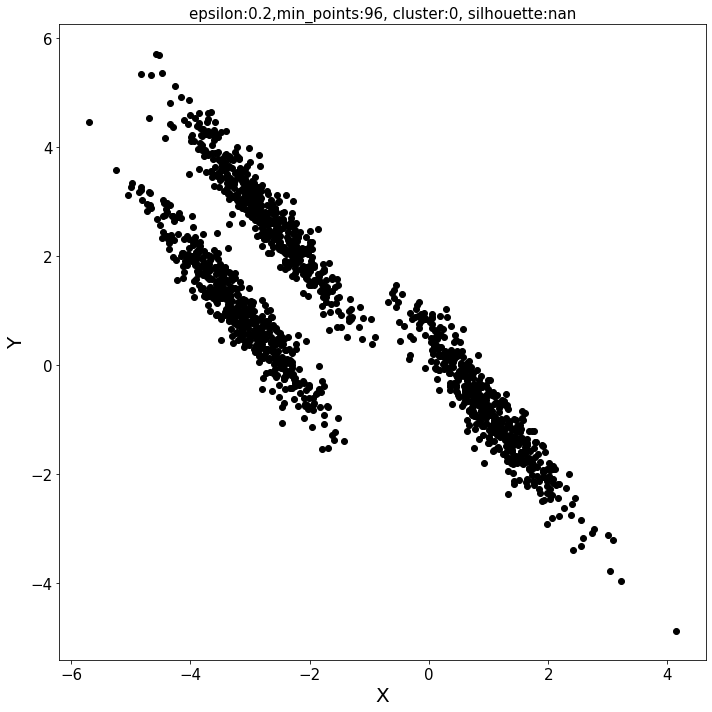

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


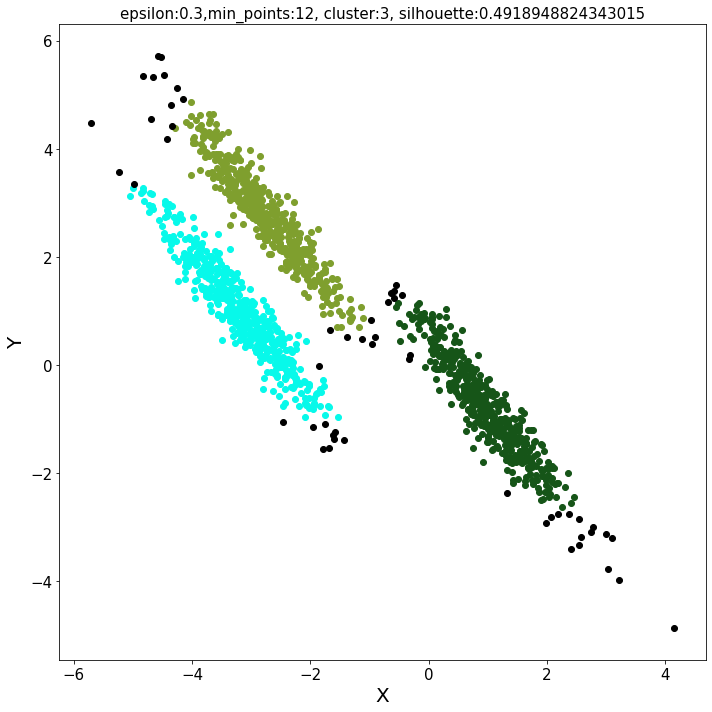

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


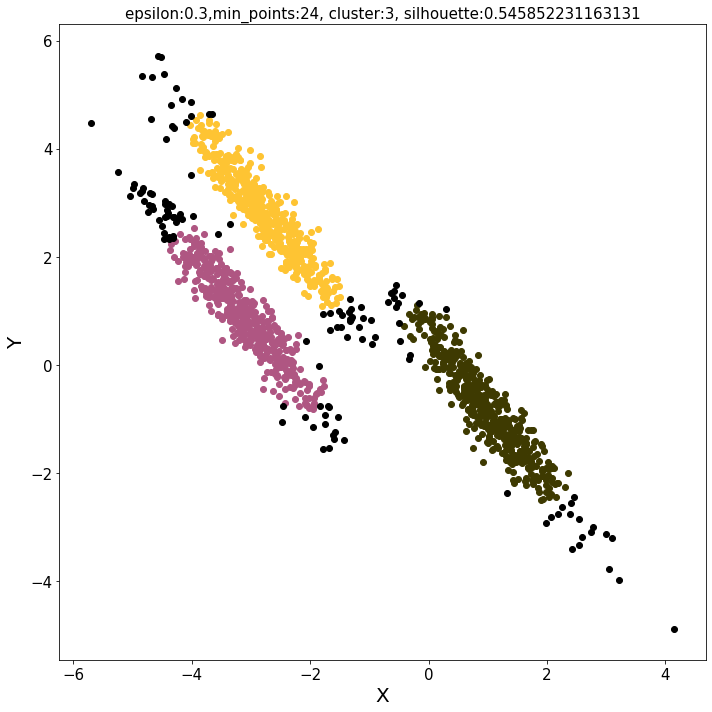

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


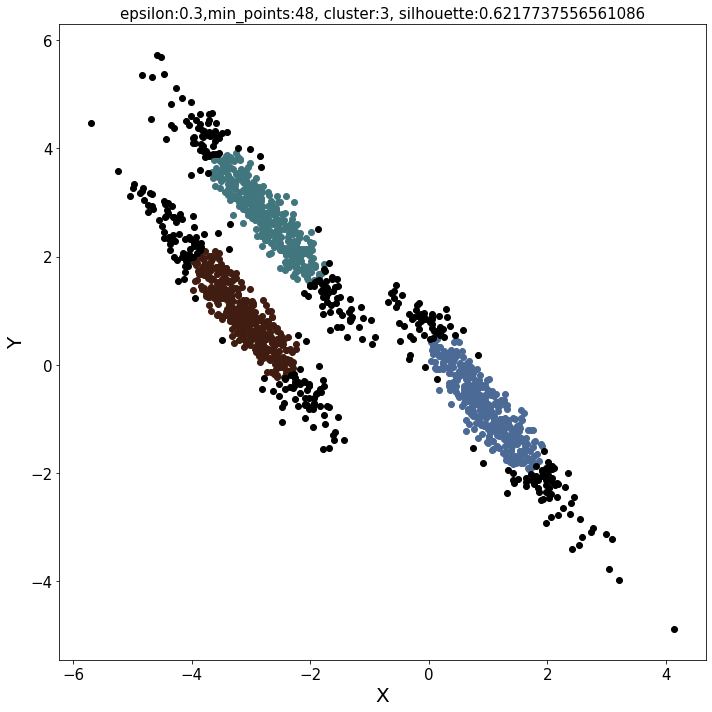

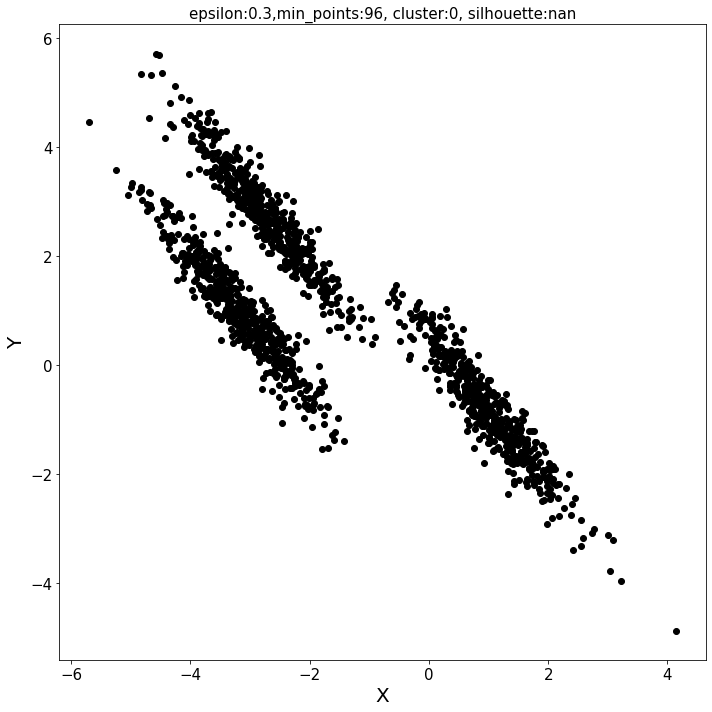

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


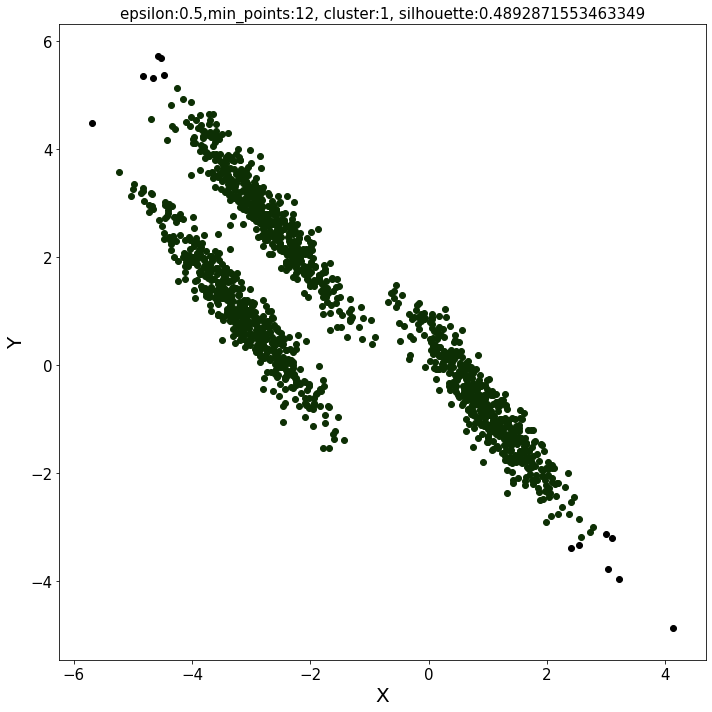

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


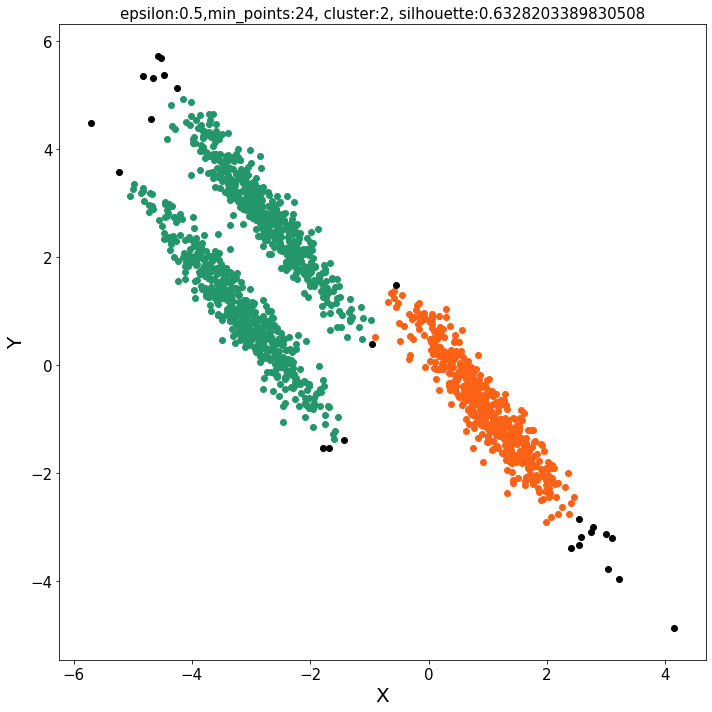

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


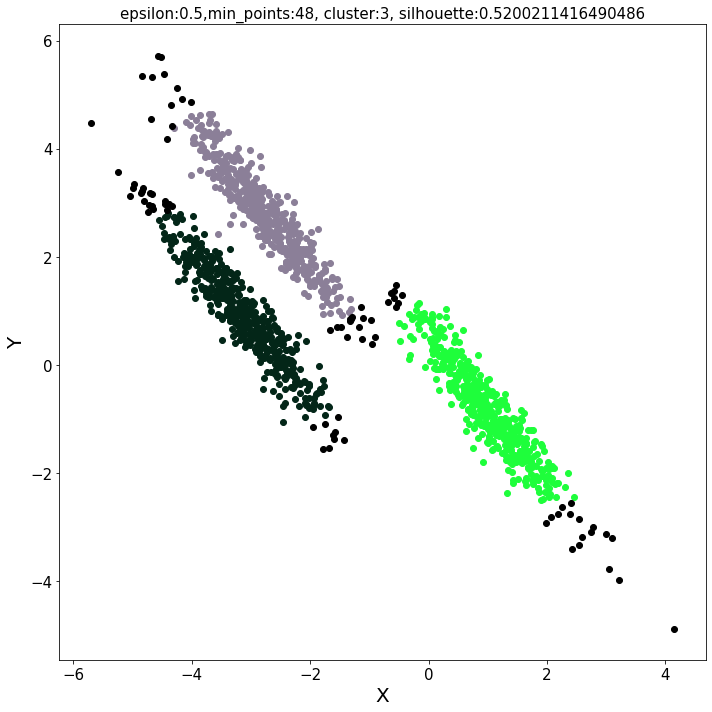

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


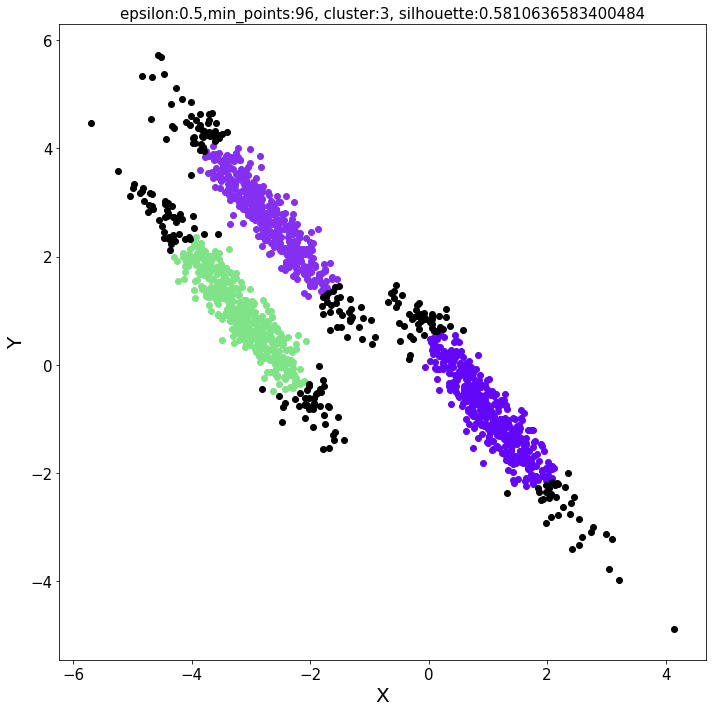

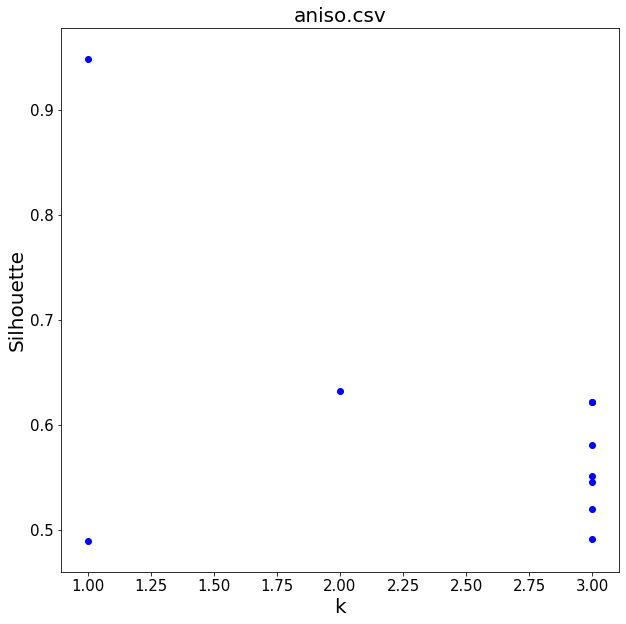

In [15]:
# For the aniso dataset
base_path = r'C:\Users\wayiqin\Downloads\Data_mining\Assignment3' # path to the folder that contains the dataset.csv.
dataset_name = 'aniso.csv'
dataset_path = rf'{base_path}/{dataset_name}'
dataset = pd.read_csv(dataset_path, header=None) # extract each trasaction in each line
epsilons = [0.2, 0.3, 0.5]
min_points = [12, 24, 48, 96]
m = dataset
cluster_number = []
silhouettes = []
for epsilon in epsilons:
    for min_point in min_points:
        UNCLASSIFIED = False
        NOISE = None        
        clusters = dbscan(m, epsilon, min_point)
        if None in list(set(clusters)):
            k = len(list(set(clusters)))-1
            cluster_number.append(k)
        else:
            k = len(list(set(clusters)))
            cluster_number.append(k)
        silhouette = silhouette_scores(m, clusters)
        silhouettes.append(silhouette)
        draw(m, clusters, epsilon, min_point, silhouette, k)

# draw the silhouettes in a graph
plt.figure(figsize=(10, 10))
plt.title(dataset_name, fontsize = 20.0)
plt.scatter(cluster_number, silhouettes, marker='o', c='blue')
plt.xticks(fontsize = 15.0)
plt.yticks(fontsize = 15.0)
plt.xlabel('k', fontsize = 20.0)
plt.ylabel('Silhouette', fontsize = 20.0)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


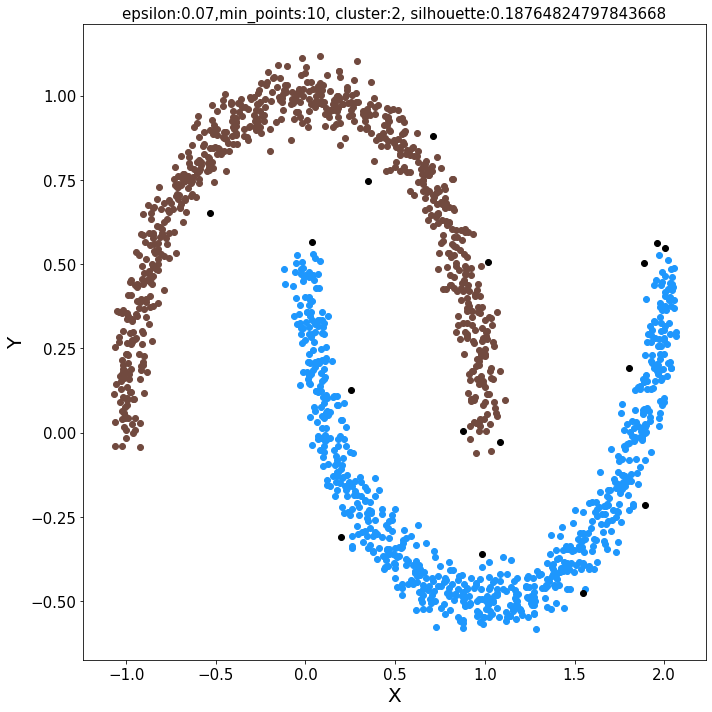

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

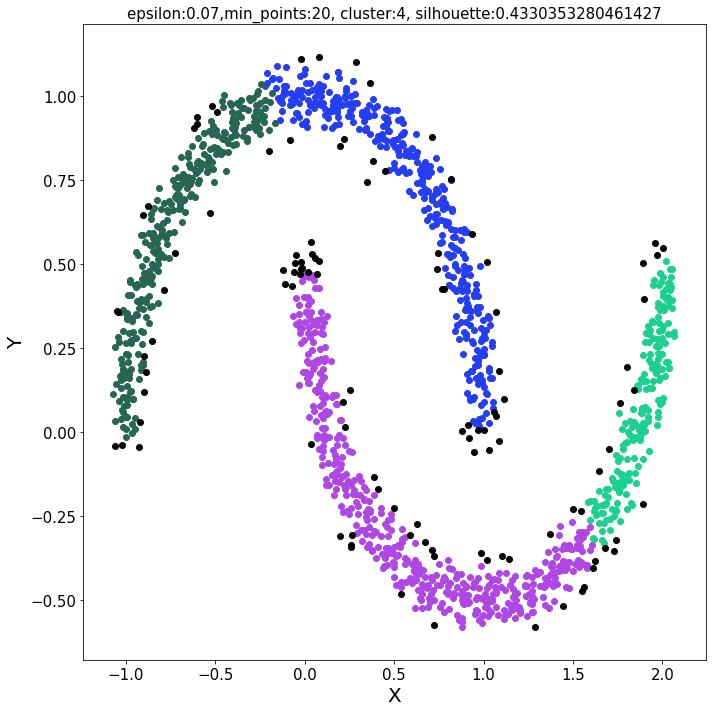

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

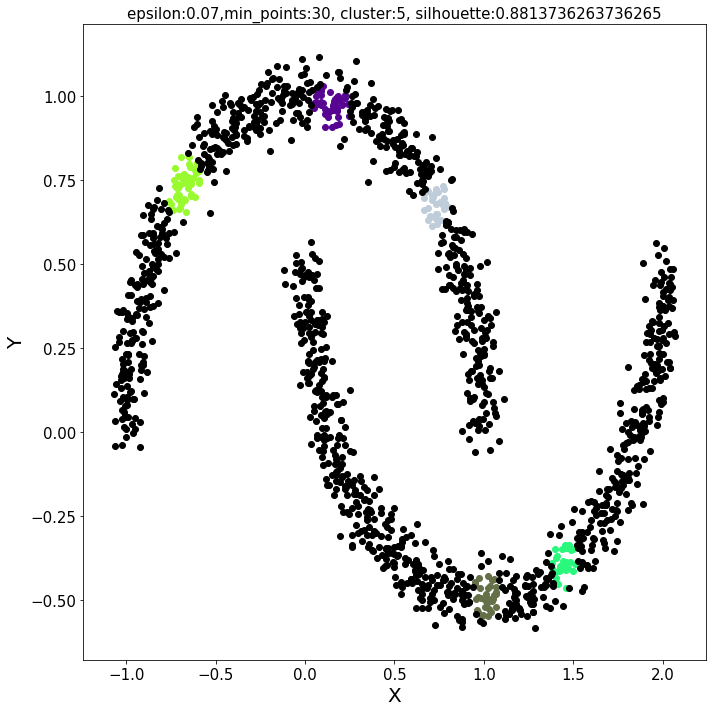

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


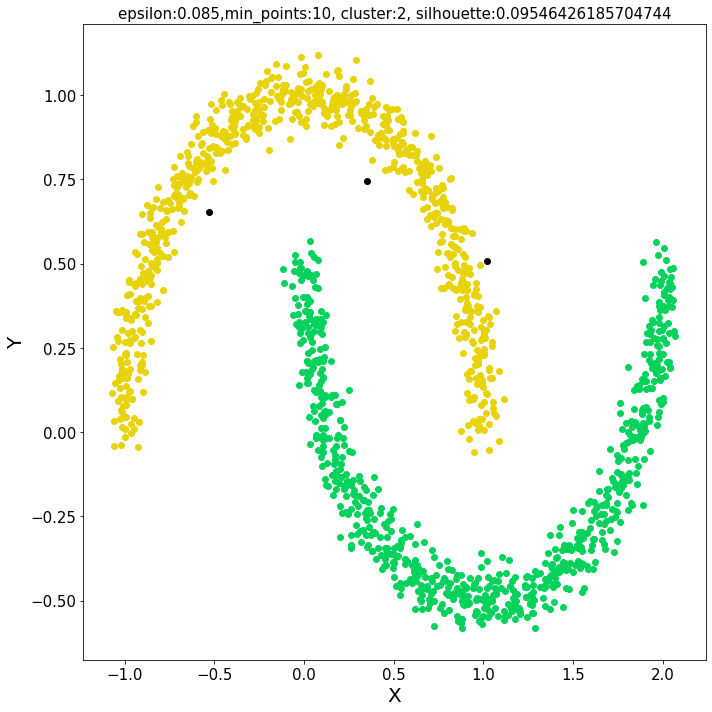

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


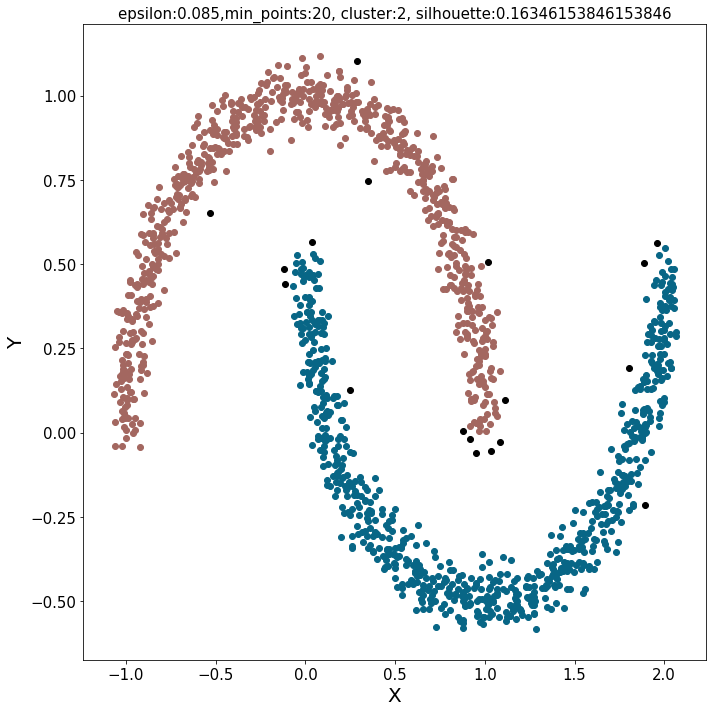

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

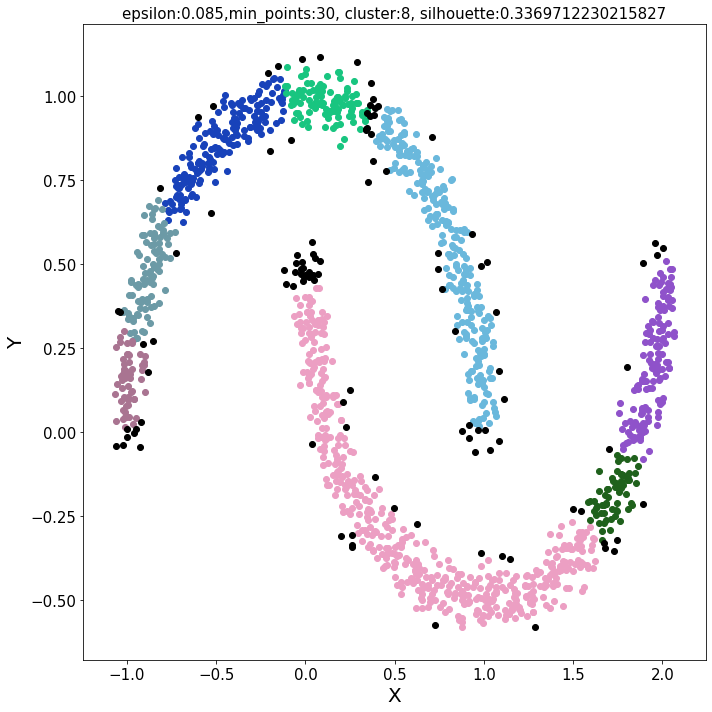

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


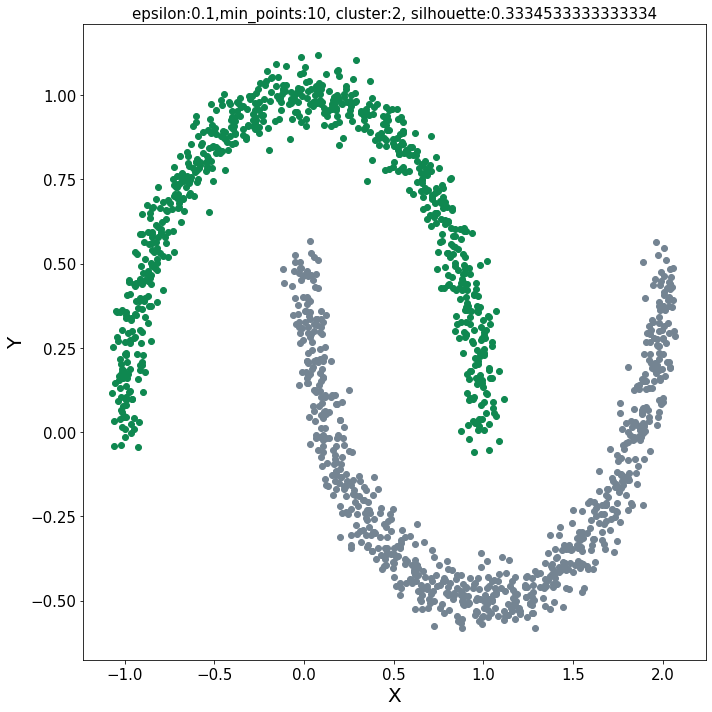

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


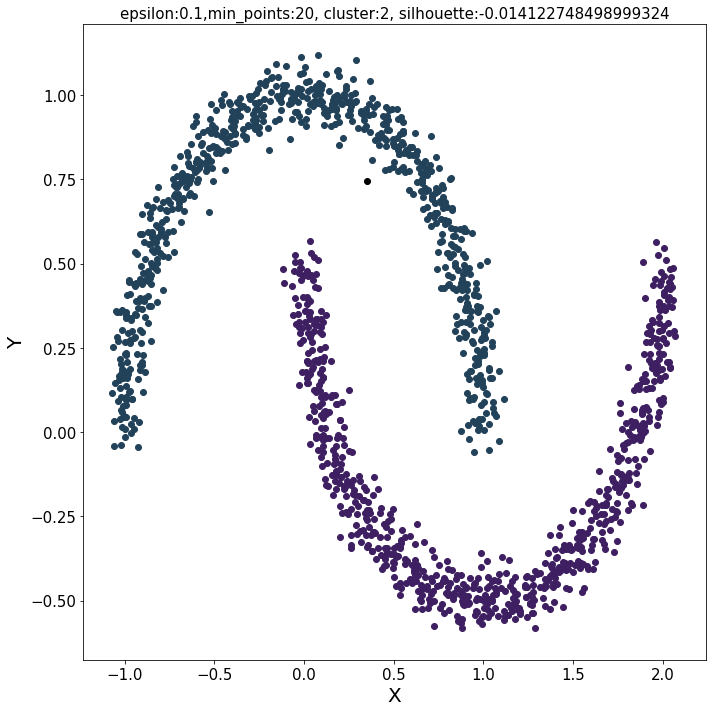

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


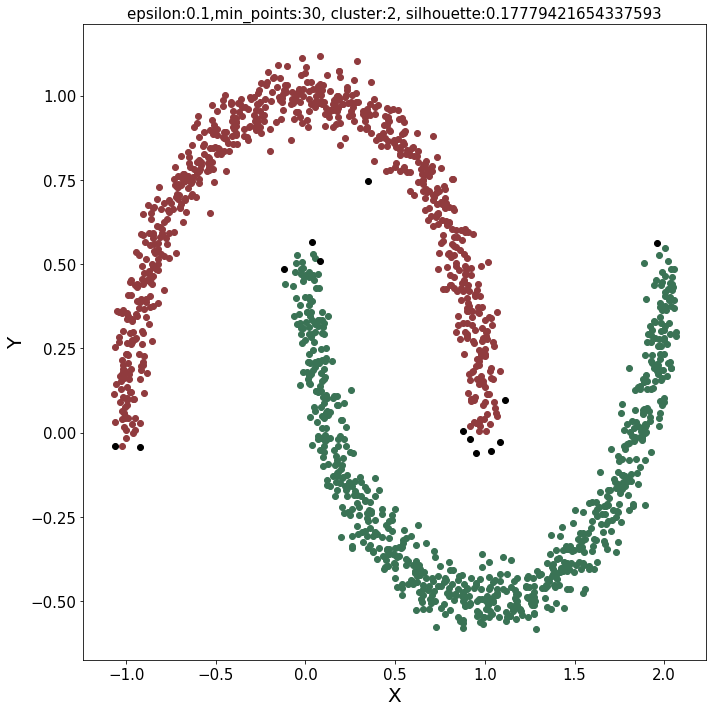

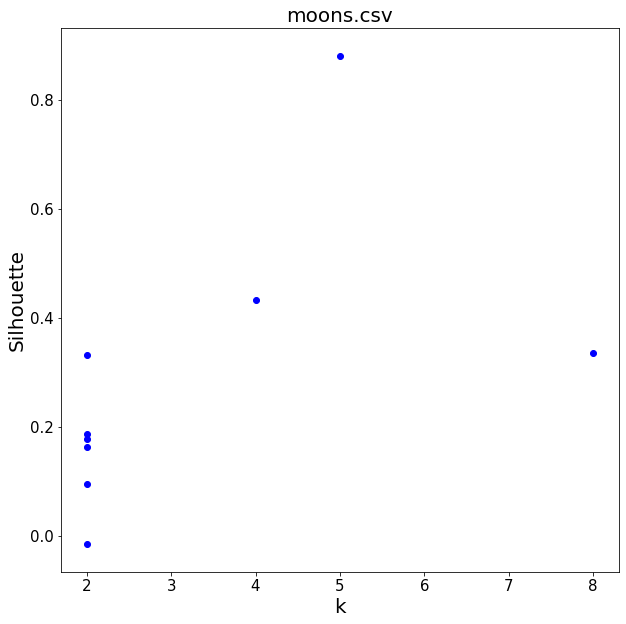

In [13]:
# For the moons dataset
base_path = r'C:\Users\wayiqin\Downloads\Data_mining\Assignment3' # path to the folder that contains the dataset.csv.
dataset_name = 'moons.csv'
dataset_path = rf'{base_path}/{dataset_name}'
dataset = pd.read_csv(dataset_path, header=None) # extract each trasaction in each line
epsilons = [0.07, 0.085, 0.1]
min_points = [10, 20, 30]
m = dataset
cluster_number = []
silhouettes = []
for epsilon in epsilons:
    for min_point in min_points:
        UNCLASSIFIED = False
        NOISE = None        
        clusters = dbscan(m, epsilon, min_point)
        if None in list(set(clusters)):
            k = len(list(set(clusters)))-1
            cluster_number.append(k)
        else:
            k = len(list(set(clusters)))
            cluster_number.append(k)
        silhouette = silhouette_scores(m, clusters)
        silhouettes.append(silhouette)
        draw(m, clusters, epsilon, min_point, silhouette, k)

# draw the silhouettes in a graph
plt.figure(figsize=(10, 10))
plt.title(dataset_name, fontsize = 20.0)
plt.scatter(cluster_number, silhouettes, marker='o', c='blue')
plt.xticks(fontsize = 15.0)
plt.yticks(fontsize = 15.0)
plt.xlabel('k', fontsize = 20.0)
plt.ylabel('Silhouette', fontsize = 20.0)
plt.show()